In [1]:
from __future__ import print_function, division
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

import copy

plt.ion()   # interactive mode
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=ff51f453e4af9c017b461ef898ce6a5c0cab51eb2bfeed929136d1dc3950d2b9
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [3]:
# %ls drive/MyDrive/MyThesis/oxford/Master


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_transforms = {
    'Train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    'Validation': transforms.Compose([
                              transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ]),
    'Testing': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# data_dir  = 'drive/MyDrive/MyThesis/hymenoptera_data/*'
data_dir = 'drive/MyDrive/MyThesis/oxford/Master'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Validation','Testing']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Validation','Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Validation','Testing']}

class_names = image_datasets['Train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(class_names)
print(dataloaders['Train'])

['Abyssinian', 'Russian_Blue', 'Sphynx', 'american_bulldog', 'american_pitbull', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


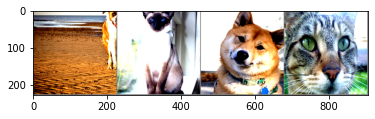

saint_bernard siamese shiba_inu egyptian_mau


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(dataloaders['Train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [8]:
metrics_eval_resnet = [] 
metrics_eval_effecientNet = [] 
def train_model(model, model_name,criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
   
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # inputs = inputs
                # labels = labels

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if model_name == "efficientNet-B7":
                metrics_eval_effecientNet.append(epoch_acc)
                # print("berhasil tersimpan epoch efficientNet")
            else:
                metrics_eval_resnet.append(epoch_acc)
                # print("berhasil tersimpan epoch resnet")

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
#Finetuning the convnet

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 37.

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 37)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [11]:
from efficientnet_pytorch import EfficientNet
model_2 = EfficientNet.from_pretrained('efficientnet-b7')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


In [12]:
model_2.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
num_ftrs = model_2._fc.in_features
# print(num_ftrs)
model_2._fc = nn.Linear(num_ftrs, 37)

model_2_GPU = model_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_2_GPU.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# print(model_2_GPU)

In [14]:
model_2_GPU = train_model(model_2_GPU,"efficientNet-B7", criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 1/20
----------
Train Loss: 2.2800 Acc: 0.4522
Validation Loss: 1.2492 Acc: 0.8590

Epoch 2/20
----------
Train Loss: 1.1627 Acc: 0.6770
Validation Loss: 0.6968 Acc: 0.8928

Epoch 3/20
----------
Train Loss: 0.9522 Acc: 0.7261
Validation Loss: 0.4847 Acc: 0.9055

Epoch 4/20
----------
Train Loss: 0.8001 Acc: 0.7691
Validation Loss: 0.3528 Acc: 0.9196

Epoch 5/20
----------
Train Loss: 0.7183 Acc: 0.7989
Validation Loss: 0.3191 Acc: 0.9168

Epoch 6/20
----------
Train Loss: 0.6694 Acc: 0.8037
Validation Loss: 0.2716 Acc: 0.9224

Epoch 7/20
----------
Train Loss: 0.6209 Acc: 0.8202
Validation Loss: 0.2329 Acc: 0.9281

Epoch 8/20
----------
Train Loss: 0.5720 Acc: 0.8363
Validation Loss: 0.2333 Acc: 0.9281

Epoch 9/20
----------
Train Loss: 0.5674 Acc: 0.8377
Validation Loss: 0.2309 Acc: 0.9281

Epoch 10/20
----------
Train Loss: 0.5461 Acc: 0.8424
Validation Loss: 0.2269 Acc: 0.9351

Epoch 11/20
----------
Train Loss: 0.5568 Acc: 0.8386
Validation Loss: 0.2249 Acc: 0.9323

Epoch 12

In [16]:
#Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
train_loss = [2.2800,1.1627,0.9522,0.8001,0.7183,0.6694,0.6209,0.5720,0.5674,0.5461,0.5568,0.5389,0.5050,0.5195,0.5089,0.5139,0.5177,0.5036,0.5205]
train_acc = [0.4522,0.6770,0.7261,0.7691,0.7989,0.8037,0.8202,0.8363,0.8377,0.8424,0.8386,0.8449,0.8515,0.8523,0.8530,0.8563,0.8497,0.8520,0.8478]

val_loss = [1.2492,0.6968,0.4847,0.3528,0.3191,0.2716,0.2329,0.2333,0.2309,0.2269,0.2249,0.2153,0.2185,0.2128,0.2154,0.2161,0.2126,0.2086,0.2134]
val_acc = [0.8590,0.8928,0.9055,0.9196,0.9168,0.9224,0.9281,0.9281,0.9281,0.9351,0.9323,0.9323,0.9281,0.9337,0.9351,0.9323,0.9337,0.9337,0.9323]

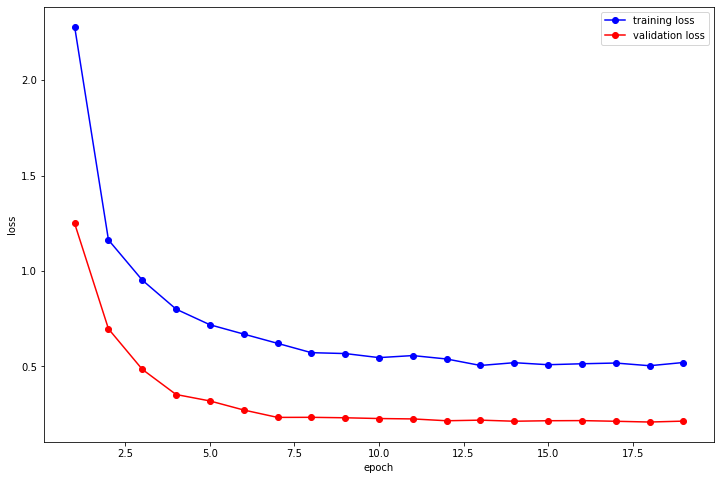

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(range(1,len(train_loss)+1),train_loss,'blue',label = 'training loss',marker="o")
plt.plot(range(1,len(val_loss)+1),val_loss,'r',label = 'validation loss',marker="o")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

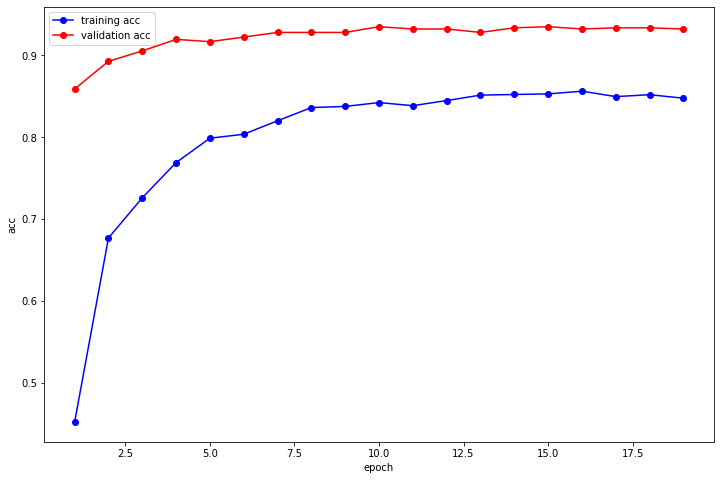

In [7]:
plt.figure(figsize=(12,8))
plt.plot(range(1,len(train_acc)+1),train_acc,'b',label = 'training acc',marker="o")
plt.plot(range(1,len(val_acc)+1),val_acc,'r',label = 'validation acc',marker="o")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()

In [15]:
# Each epoch has a training and validation phase
for phase in ['Testing']:
    model_2_GPU.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        # optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'Train'):
            outputs = model_2_GPU(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

Testing Loss: 0.4755 Acc: 0.8621


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


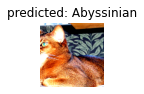

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


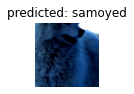

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


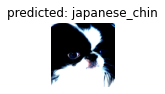

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


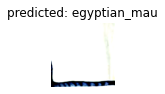

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


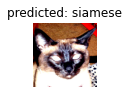

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


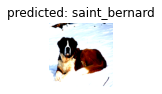

In [17]:
visualize_model(model_2_GPU)

In [18]:
torch.save(model_2_GPU,'drive/MyDrive/MyThesis/efb750oxford.model')